# DAT210x - Programming with Python for DS

## Module5- Lab7

In [1]:
import random, math
import pandas as pd
import numpy as np
import scipy.io
import matplotlib

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier

matplotlib.style.use('ggplot') # Look Pretty


# Leave this alone until indicated:
Test_PCA = False

### A Convenience Function

This method is for your visualization convenience only. You aren't expected to know how to put this together yourself, although you should be able to follow the code by now:

In [2]:
def plotDecisionBoundary(model, X, y):
    print("Plotting...")

    fig = plt.figure()
    ax = fig.add_subplot(111)

    padding = 0.1
    resolution = 0.1

    #(2 for benign, 4 for malignant)
    colors = {2:'royalblue', 4:'lightsalmon'} 


    # Calculate the boundaris
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * padding
    y_min -= y_range * padding
    x_max += x_range * padding
    y_max += y_range * padding

    # Create a 2D Grid Matrix. The values stored in the matrix
    # are the predictions of the class at at said location
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # What class does the classifier say?
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour map
    plt.contourf(xx, yy, Z, cmap=plt.cm.seismic)
    plt.axis('tight')

    # Plot your testing points as well...
    for label in np.unique(y):
        indices = np.where(y == label)
        plt.scatter(X[indices, 0], X[indices, 1], c=colors[label], alpha=0.8)

    p = model.get_params()
    plt.title('K = ' + str(p['n_neighbors']))
    plt.show()

### The Assignment

Load in the dataset, identify nans, and set proper headers. Be sure to verify the rows line up by looking at the file in a text editor.

In [3]:
df = pd.read_csv('Datasets/breast-cancer-wisconsin.data', header=None)
df.columns = ['sample', 'thickness', 'size', 'shape', 'adhesion', 'epithelial', 'nuclei', 'chromatin', 'nucleoli', 'mitoses', 'status']

print(df.dtypes) # Feature nuclei must be an int64 like others.
print(df.isnull().sum()) # There is no null, maybe because it is not filled with NA values format.

df.nuclei = pd.to_numeric(df.nuclei, errors='coerce')

print(df.dtypes)
print(df.isnull().sum()) # Now there are 16 nans values

sample         int64
thickness      int64
size           int64
shape          int64
adhesion       int64
epithelial     int64
nuclei        object
chromatin      int64
nucleoli       int64
mitoses        int64
status         int64
dtype: object
sample        0
thickness     0
size          0
shape         0
adhesion      0
epithelial    0
nuclei        0
chromatin     0
nucleoli      0
mitoses       0
status        0
dtype: int64
sample          int64
thickness       int64
size            int64
shape           int64
adhesion        int64
epithelial      int64
nuclei        float64
chromatin       int64
nucleoli        int64
mitoses         int64
status          int64
dtype: object
sample         0
thickness      0
size           0
shape          0
adhesion       0
epithelial     0
nuclei        16
chromatin      0
nucleoli       0
mitoses        0
status         0
dtype: int64


Copy out the status column into a slice, then drop it from the main dataframe. Always verify you properly executed the drop by double checking (printing out the resulting operating)! Many people forget to set the right axis here.

If you goofed up on loading the dataset and notice you have a `sample` column, this would be a good place to drop that too if you haven't already.

In [4]:
y = df[['status']]
X = df.drop(['status', 'sample'], axis=1)

With the labels safely extracted from the dataset, replace any nan values with the mean feature / column value:

In [5]:
print(X.describe())
X.fillna(X.mean(), inplace=True)
print(X.describe()) # Comparing describes() to check anything strange happend after fillna().
print(X.head(10))

        thickness        size       shape    adhesion  epithelial      nuclei  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  683.000000   
mean     4.417740    3.134478    3.207439    2.806867    3.216023    3.544656   
std      2.815741    3.051459    2.971913    2.855379    2.214300    3.643857   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      2.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
50%      4.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
75%      6.000000    5.000000    5.000000    4.000000    4.000000    6.000000   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

        chromatin    nucleoli     mitoses  
count  699.000000  699.000000  699.000000  
mean     3.437768    2.866953    1.589413  
std      2.438364    3.053634    1.715078  
min      1.000000    1.000000    1.000000  
25%      2.000000    1.000000    1.000000  
50%   

Do train_test_split. Use the same variable names as on the EdX platform in the reading material, but set the random_state=7 for reproducibility, and keep the test_size at 0.5 (50%).

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7)

Experiment with the basic SKLearn preprocessing scalers. We know that the features consist of different units mixed in together, so it might be reasonable to assume feature scaling is necessary. Print out a description of the dataset, post transformation. Recall: when you do pre-processing, which portion of the dataset is your model trained upon? Also which portion(s) of your dataset actually get transformed?

In [7]:
#T = preprocessing.StandardScaler().fit(X_train)
T = preprocessing.MinMaxScaler().fit(X_train)
#T = preprocessing.RobustScaler().fit(X_train)
#T = preprocessing.Normalizer().fit(X_train)

X_train = T.transform(X_train)
X_test = T.transform(X_test)

### Dimensionality Reduction

PCA and Isomap are your new best friends

In [8]:
model = None

if Test_PCA:
    print('Computing 2D Principle Components')
    # TODO: Implement PCA here. Save your model into the variable 'model'.
    # You should reduce down to two dimensions.
    
    model = PCA(n_components = 2, svd_solver='full')

else:
    print('Computing 2D Isomap Manifold')
    # TODO: Implement Isomap here. Save your model into the variable 'model'
    # Experiment with K values from 5-10.
    # You should reduce down to two dimensions.

    model = manifold.Isomap(n_neighbors=5, n_components = 2)

Computing 2D Isomap Manifold


Train your model against data_train, then transform both `data_train` and `data_test` using your model. You can save the results right back into the variables themselves.

In [9]:
model.fit(X_train)

X_train = model.transform(X_train)
X_test = model.transform(X_test)

Implement and train `KNeighborsClassifier` on your projected 2D training data here. You can name your variable `knmodel`. You can use any `K` value from 1 - 15, so play around with it and see what results you can come up. Your goal is to find a good balance where you aren't too specific (low-K), nor are you too general (high-K). You should also experiment with how changing the weights parameter affects the results.

In [10]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance') # weights = uniform
knn.fit(X_train, y_train)

/Users/alvarocebrian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

Be sure to always keep the domain of the problem in mind! It's WAY more important to errantly classify a benign tumor as malignant, and have it removed, than to incorrectly leave a malignant tumor, believing it to be benign, and then having the patient progress in cancer. Since the UDF weights don't give you any class information, the only way to introduce this data into SKLearn's KNN Classifier is by "baking" it into your data. For example, randomly reducing the ratio of benign samples compared to malignant samples from the training set.

Calculate and display the accuracy of the testing set:

In [11]:
accuracy = knn.score(X_test, y_test)
print(accuracy)

0.962857142857


Plotting...


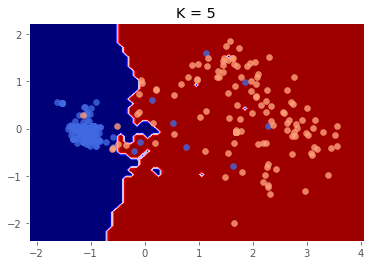

In [12]:
plotDecisionBoundary(knn, X_test, y_test)